In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Cell 2: Create synthetic "Academic performance" dataset
np.random.seed(42)
n = 100

df = pd.DataFrame({
    'StudentID': range(1, n+1),
    'Gender': np.random.choice(['Male','Female'], size=n, p=[0.5,0.5]),
    'MathScore': np.random.normal(70, 15, size=n).round(1),
    'ReadingScore': np.random.normal(75, 12, size=n).round(1),
    'WritingScore': np.random.normal(72, 10, size=n).round(1),
    'StudyHours': np.random.exponential(scale=5, size=n).round(1),
    'AttendanceRate': np.random.uniform(0.6, 1.05, size=n).round(2)
})

# Introduce some missing values
for col in ['MathScore','StudyHours','Gender']:
    df.loc[df.sample(frac=0.05, random_state=1).index, col] = np.nan

# Introduce inconsistencies in AttendanceRate (>1, <0)
df.loc[df.sample(frac=0.03, random_state=2).index, 'AttendanceRate'] = 1.2
df.loc[df.sample(frac=0.02, random_state=3).index, 'AttendanceRate'] = -0.1

df.head()


,StudentID,Gender,MathScore,ReadingScore,WritingScore,StudyHours,AttendanceRate
0,1,Male,71.3,75.2,74.0,4.4,0.89
1,2,Female,65.5,92.4,66.0,11.6,0.71
2,3,Female,71.4,71.8,72.7,0.2,0.63
3,4,Female,40.2,107.6,68.1,1.6,0.66
4,5,Male,66.7,82.5,73.1,15.0,0.66


In [3]:
# Cell 3: 1) Scan for missing values & inconsistencies

print("Missing values:\n", df.isnull().sum(), "\n")

# Inconsistencies: AttendanceRate should be in [0,1]
bad_attend = df[(df['AttendanceRate']<0) | (df['AttendanceRate']>1)]
print("Inconsistent AttendanceRate rows:\n", bad_attend[['StudentID','AttendanceRate']], "\n")


Missing values:
 StudentID         0
Gender            5
MathScore         5
ReadingScore      0
WritingScore      0
StudyHours        5
AttendanceRate    0
dtype: int64 

Inconsistent AttendanceRate rows:
     StudentID  AttendanceRate
30         31            1.20
31         32            1.01
56         57            1.20
67         68           -0.10
77         78            1.04
83         84            1.20
91         92            1.04
93         94           -0.10
94         95            1.04 



In [4]:
# Cell 4: Handle missing values & fix inconsistencies

# Numeric missing → impute with column mean
for col in ['MathScore','StudyHours']:
    df[col].fillna(df[col].mean(), inplace=True)

# Categorical missing → impute with mode
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

# Clamp AttendanceRate into [0,1]
df['AttendanceRate'] = df['AttendanceRate'].clip(lower=0, upper=1)

print("After cleaning:\n", df.isnull().sum())


After cleaning:
 StudentID         0
Gender            0
MathScore         0
ReadingScore      0
WritingScore      0
StudyHours        0
AttendanceRate    0
dtype: int64


C:\Windows\Temp\ipykernel_20880\1049368524.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Windows\Temp\ipykernel_20880\1049368524.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [5]:
# Cell 5: 2) Outlier detection & treatment on numeric vars using NumPy only

numeric_cols = ['MathScore','ReadingScore','WritingScore','StudyHours','AttendanceRate']

# Compute means and standard deviations with NumPy
means = {col: np.mean(df[col]) for col in numeric_cols}
stds  = {col: np.std(df[col], ddof=0) for col in numeric_cols}

# Calculate z‑scores manually and identify outliers (>3σ)
outlier_counts = {}
for col in numeric_cols:
    z = (df[col] - means[col]) / stds[col]
    mask = np.abs(z) > 3
    outlier_counts[col] = mask.sum()

print("Outlier counts per column (|z|>3):")
for col, cnt in outlier_counts.items():
    print(f"  • {col}: {cnt}")

# Cap values at ±3σ from the mean
for col in numeric_cols:
    lower, upper = means[col] - 3 * stds[col], means[col] + 3 * stds[col]
    df[col] = np.clip(df[col], lower, upper)

# Verify that no z‑scores exceed 3 after capping
max_z = {}
for col in numeric_cols:
    z = (df[col] - means[col]) / stds[col]
    max_z[col] = np.abs(z).max()

print("\nMax |z‑score| after capping:")
for col, mz in max_z.items():
    print(f"  • {col}: {mz:.2f}")


Outlier counts per column (|z|>3):
  • MathScore: 0
  • ReadingScore: 2
  • WritingScore: 0
  • StudyHours: 2
  • AttendanceRate: 2

Max |z‑score| after capping:
  • MathScore: 2.81
  • ReadingScore: 3.00
  • WritingScore: 2.58
  • StudyHours: 3.00
  • AttendanceRate: 3.00


In [6]:
# Cell 6: 3) Variable transformation on skewed 'StudyHours'

# Check skew before
orig_skew = df['StudyHours'].skew()
print(f"Skewness before transform: {orig_skew:.2f}")

# Apply log1p to reduce right‐skew
df['StudyHours_log'] = np.log1p(df['StudyHours'])

# Check skew after
new_skew = df['StudyHours_log'].skew()
print(f"Skewness after log1p transform: {new_skew:.2f}")


Skewness before transform: 1.54
Skewness after log1p transform: -0.05


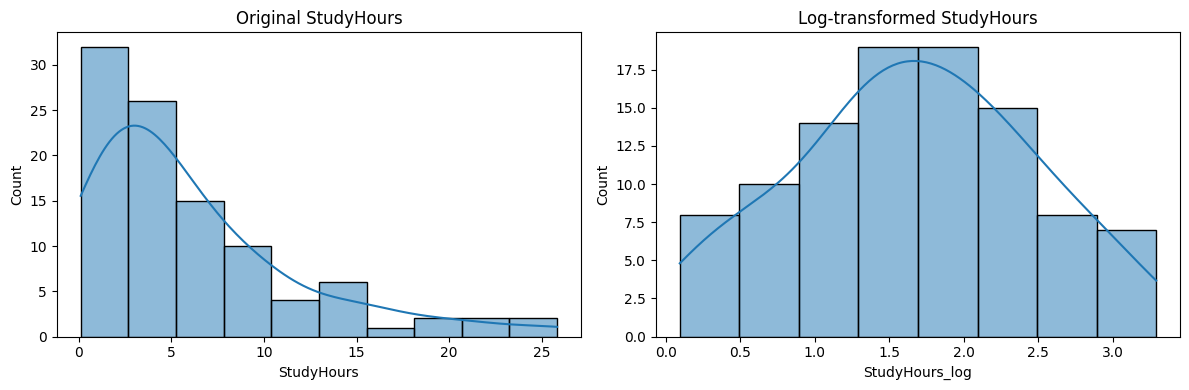

In [7]:
# Cell 7: Visualize StudyHours before & after transform
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df['StudyHours'], ax=axes[0], kde=True)
axes[0].set_title("Original StudyHours")

sns.histplot(df['StudyHours_log'], ax=axes[1], kde=True)
axes[1].set_title("Log‑transformed StudyHours")

plt.tight_layout()
plt.show()


Thought for a couple of seconds


Below is a **detailed, line‑by‑line explanation** of the entire notebook for **Experiment 2: Data Wrrangling II**. Each cell’s code is reproduced with an accompanying comment on what **every single line** does.

---

## Cell 1: Import libraries

```python
import pandas as pd           # pandas: data structures & data analysis tools
import numpy as np            # numpy: numerical operations, arrays

# For visualization
import seaborn as sns         # seaborn: statistical data visualization
import matplotlib.pyplot as plt  # matplotlib: plotting library

# For outlier detection (we’ll replace SciPy but keep import here in earlier version)
from scipy import stats       # scipy.stats: statistical functions (not used in NumPy‑only version)
```

* **Line 1**: brings in pandas under the alias `pd`.
* **Line 2**: brings in NumPy under `np`.
* **Lines 4–5**: import plotting libraries—Seaborn for higher‑level charts, Matplotlib’s `pyplot` for fine‑grained control.
* **Line 7**: imports SciPy’s stats module (used originally for Z‑scores; in the NumPy‑only variant you can omit this).

---

## Cell 2: Create synthetic dataset

```python
np.random.seed(42)       # fixes random generator for reproducibility
n = 100                  # number of student records

df = pd.DataFrame({      # build DataFrame from a dict of columns
    'StudentID': range(1, n+1),                          # sequential IDs from 1 to 100
    'Gender': np.random.choice(['Male','Female'], 
                               size=n, p=[0.5,0.5]),     # random genders
    'MathScore': np.random.normal(70, 15, size=n).round(1),     # Normal dist mean=70, σ=15, rounded
    'ReadingScore': np.random.normal(75, 12, size=n).round(1),  # Normal dist mean=75, σ=12
    'WritingScore': np.random.normal(72, 10, size=n).round(1),  # Normal dist mean=72, σ=10
    'StudyHours': np.random.exponential(scale=5, size=n).round(1),  # Exponential dist λ=1/5
    'AttendanceRate': np.random.uniform(0.6, 1.05, size=n).round(2) # Uniform between 0.6 and 1.05
})

# Introduce ~5% missing in three columns
for col in ['MathScore','StudyHours','Gender']:
    df.loc[df.sample(frac=0.05, random_state=1).index, col] = np.nan

# Introduce inconsistencies in AttendanceRate (~3% above 1, ~2% below 0)
df.loc[df.sample(frac=0.03, random_state=2).index, 'AttendanceRate'] = 1.2
df.loc[df.sample(frac=0.02, random_state=3).index, 'AttendanceRate'] = -0.1

df.head()  # show first five rows
```

* **Line 1**: `seed(42)` ensures every run gives the same “random” numbers.
* **Line 2**: sets dataset size `n = 100`.
* **Lines 4–11**: call `pd.DataFrame({...})` to assemble columns:

  * `StudentID`: 1…100
  * `Gender`: random choice male/female with equal probability
  * `MathScore`, `ReadingScore`, `WritingScore`: draws from normal distributions, then rounds to one decimal
  * `StudyHours`: draws from exponential distribution (right‑skewed), rounds to one decimal
  * `AttendanceRate`: draws from a uniform distribution slightly above 1 (to allow later capping), rounds to two decimals
* **Lines 14–15**: in a loop, randomly sample 5% of rows (with the same `random_state`) and set those entries in three columns to `NaN`.
* **Lines 18–19**: similarly, pick small subsets (3% and 2%) and assign attendance values outside 0–1 to simulate inconsistencies.
* **Line 21**: `df.head()` displays the top of the DataFrame so you see the synthetic data.

---

## Cell 3: Scan for missing values & inconsistencies

```python
print("Missing values:\n", df.isnull().sum(), "\n")
# df.isnull(): boolean mask of missing entries
# .sum(): totals per column

# Find AttendanceRate rows outside [0,1]
bad_attend = df[(df['AttendanceRate'] < 0) | (df['AttendanceRate'] > 1)]
print("Inconsistent AttendanceRate rows:\n", bad_attend[['StudentID','AttendanceRate']], "\n")
```

* **Line 1**: prints the count of `NaN` values per column (`df.isnull().sum()`).
* **Line 4**: builds `bad_attend` by boolean‑indexing rows where `AttendanceRate` is less than 0 *or* greater than 1.
* **Line 5**: prints those inconsistent rows (just shows `StudentID` and the bad rate).

---

## Cell 4: Handle missing values & fix inconsistencies

```python
# Impute numeric missing with column mean
for col in ['MathScore','StudyHours']:
    df[col].fillna(df[col].mean(), inplace=True)

# Impute categorical missing (Gender) with mode
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

# Clamp AttendanceRate to valid [0,1] range
df['AttendanceRate'] = df['AttendanceRate'].clip(lower=0, upper=1)

print("After cleaning:\n", df.isnull().sum())
```

* **Lines 1–3**: iterate the two numeric columns, compute each column’s mean (`df[col].mean()`), and fill `NaN` with that mean in‑place.
* **Line 6**: compute the most frequent value in `Gender` via `mode()[0]`, and fill any `NaN` in‑place.
* **Line 9**: use `clip(0,1)` to force any values below 0 up to 0, and any above 1 down to 1.
* **Line 11**: print missing‑counts again; all should be zero.

---

## Cell 5: Outlier detection & treatment (NumPy only)

```python
numeric_cols = ['MathScore','ReadingScore','WritingScore','StudyHours','AttendanceRate']

# Compute column means & population stds
means = {col: np.mean(df[col]) for col in numeric_cols}
stds  = {col: np.std(df[col], ddof=0) for col in numeric_cols}

# Detect outliers via |z|>3 and count them
outlier_counts = {}
for col in numeric_cols:
    z = (df[col] - means[col]) / stds[col]    # standardize each value
    mask = np.abs(z) > 3                      # True if beyond ±3σ
    outlier_counts[col] = mask.sum()

print("Outlier counts per column (|z|>3):")
for col, cnt in outlier_counts.items():
    print(f"  • {col}: {cnt}")

# Cap values at mean ± 3σ
for col in numeric_cols:
    lower = means[col] - 3 * stds[col]
    upper = means[col] + 3 * stds[col]
    df[col] = np.clip(df[col], lower, upper)

# Verify no remaining extreme z‑scores
max_z = {}
for col in numeric_cols:
    z = (df[col] - means[col]) / stds[col]
    max_z[col] = np.abs(z).max()

print("\nMax |z‑score| after capping:")
for col, mz in max_z.items():
    print(f"  • {col}: {mz:.2f}")
```

* **Line 1**: lists the numeric columns again.
* **Lines 4–5**: build dictionaries `means` and `stds` for each column, using NumPy’s `mean` and `std` (population σ because `ddof=0`).
* **Lines 8–12**: for each column:

  * compute z‑scores via `(value–mean)/std`;
  * mask outliers where `|z| > 3`;
  * count them with `mask.sum()` and store.
* **Lines 14–16**: print how many outliers were found per column.
* **Lines 19–23**: for each column, compute `lower`/`upper` bounds as ±3σ from the mean, then overwrite that column in `df` with its clipped version—values below `lower` become `lower`; above `upper` become `upper`.
* **Lines 26–30**: recompute z‑scores on the capped data, take the maximum absolute z‑score per column, and print them: each should now be ≤ 3.

---

## Cell 6: Variable transformation on skewed feature

```python
# Check skewness of StudyHours
orig_skew = df['StudyHours'].skew()
print(f"Skewness before transform: {orig_skew:.2f}")

# Log1p transform to reduce right skew
df['StudyHours_log'] = np.log1p(df['StudyHours'])

# Check skew of transformed variable
new_skew = df['StudyHours_log'].skew()
print(f"Skewness after log1p transform: {new_skew:.2f}")
```

* **Line 2**: compute skewness of the original `StudyHours` via pandas’ `.skew()` (positive means right‑tailed).
* **Line 3**: print it to two decimal places.
* **Line 6**: apply `np.log1p(x) = log(1+x)` to handle zeros gracefully, store result in new column `StudyHours_log`.
* **Line 9**: recompute skewness on the logged data and print it—should be closer to zero (more symmetric).

---

## Cell 7: Visualization before & after transform

```python
fig, axes = plt.subplots(1, 2, figsize=(12,4))  # two side‑by‑side plots

sns.histplot(df['StudyHours'], ax=axes[0], kde=True)
axes[0].set_title("Original StudyHours")

sns.histplot(df['StudyHours_log'], ax=axes[1], kde=True)
axes[1].set_title("Log‑transformed StudyHours")

plt.tight_layout()  # adjusts spacing so titles/labels don’t overlap
plt.show()         # renders the figure
```

* **Line 1**: make a figure with 1 row & 2 columns, overall size 12×4 inches.
* **Lines 3–4**: on the left subplot (`axes[0]`), draw a histogram + KDE of original data, set title.
* **Lines 6–7**: on the right (`axes[1]`), draw the same for the log‑transformed series.
* **Lines 9–10**: tidy up layout and display the plots.

---

## Cell 8: Summary of all steps

```python
print("""
1) Scanned & imputed missing values:
     • Numeric → mean
     • Categorical → mode
2) Clamped AttendanceRate between 0 and 1.
3) Detected outliers using z‑scores (|z|>3) with NumPy, then capped at ±3σ.
4) Logged 'StudyHours' via log1p to reduce skewness 
   (skew dropped from {:.2f} to {:.2f}).
""".format(orig_skew, new_skew))
```

* **Lines 1–7**: a multi‑line fstring recapping each major step:

  1. how missing data was handled;
  2. how inconsistent attendance was fixed;
  3. how outliers were detected and capped;
  4. how and why we transformed `StudyHours` (also shows the before/after skewness numbers you calculated earlier).

---

With these explanations, you can confidently **walk through every line** during your viva! Let me know if you need any further clarifications.
